# Week 5: Time Series Regression Models

In [1]:
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(tidyverse))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(gridExtra))
suppressMessages(library(fpp3))

plot_prefix <- 'plots/w05'

Warning message:
"package 'ggplot2' was built under R version 4.3.2"


## Spurious Regression with Random Walks

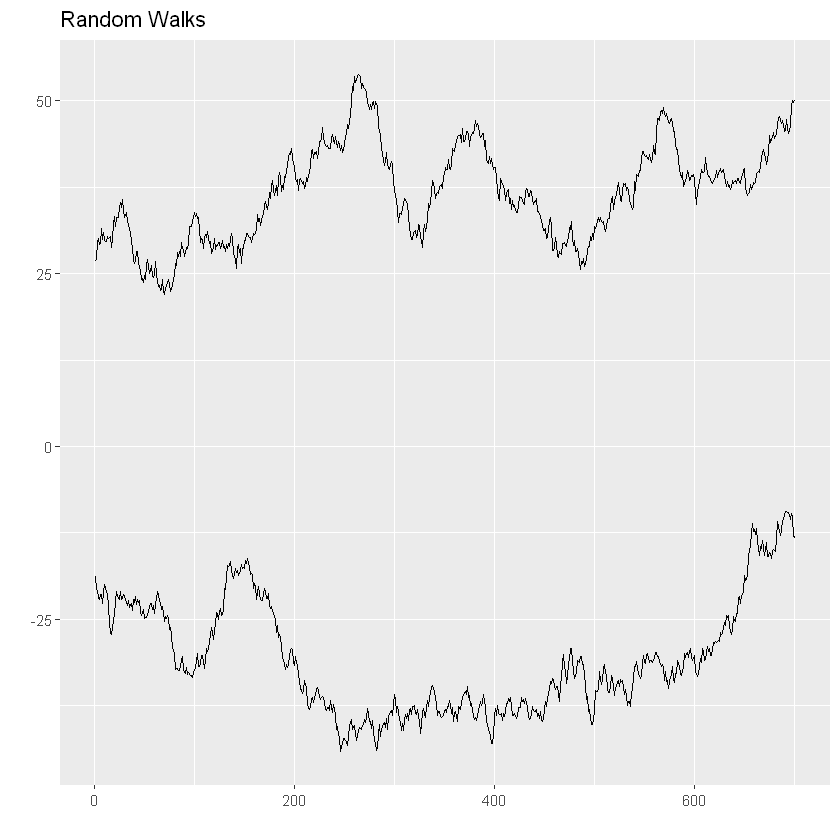

In [2]:
T <- 1000
set.seed(1357)
y <- ts(rep(0,T))
vy <- ts(rnorm(T))
for (t in 2:T){
  y[t] <- y[t-1]+vy[t]
}

set.seed(4365)
x <- ts(rep(0,T))
vx <- ts(rnorm(T))
for (t in 2:T){
  x[t] <- x[t-1]+vx[t]
}
yts <- ts(y[300:1000]) %>% as_tsibble()
xts <- ts(x[300:1000]) %>% as_tsibble()

autoplot(yts, value) + autolayer(xts, value) + labs(y='', title='Random Walks', x='')
ggsave(paste(plot_prefix, 'random_walks.png', sep='_'), height = 3, width =5)

In [3]:
y <- ts(y[300:1000])
x <- ts(x[300:1000])
spurious.ols <- lm(y~x)
summary(spurious.ols)


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.554  -5.973  -2.453   4.508  24.678 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -20.38711    1.61958 -12.588  < 2e-16 ***
x            -0.28188    0.04331  -6.508 1.45e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.954 on 699 degrees of freedom
Multiple R-squared:  0.05713,	Adjusted R-squared:  0.05578 
F-statistic: 42.35 on 1 and 699 DF,  p-value: 1.454e-10


## Income and Consumption Regression

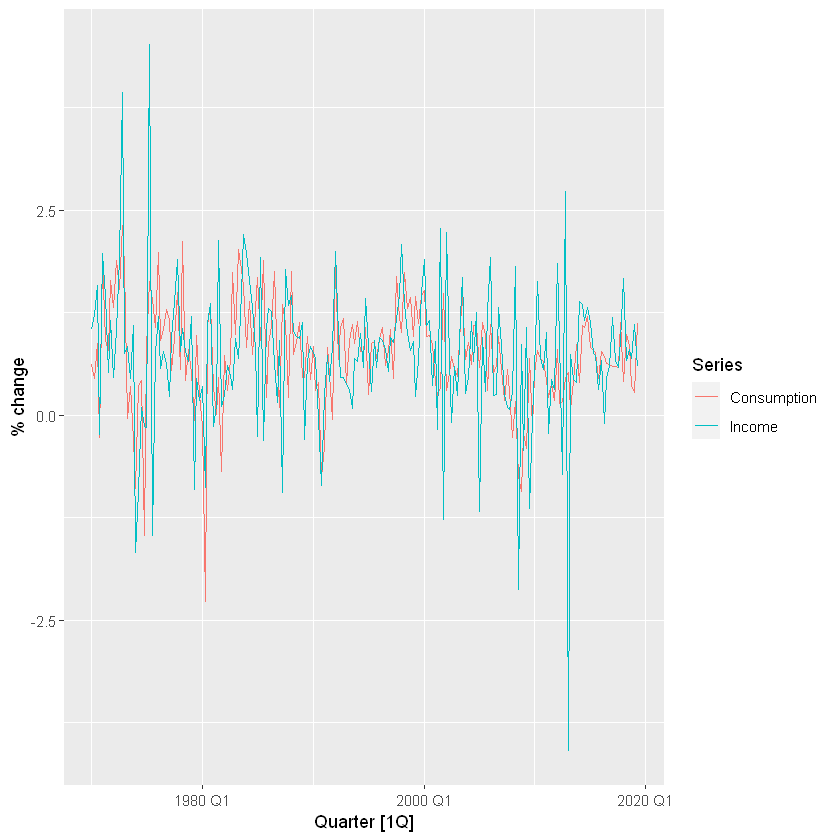

In [4]:
us_change |>
  pivot_longer(c(Consumption, Income), names_to="Series") |>
  autoplot(value) +
  labs(y = "% change")

  ggsave(paste(plot_prefix, 'consumption_income.png', sep='_'), height = 4, width =6)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


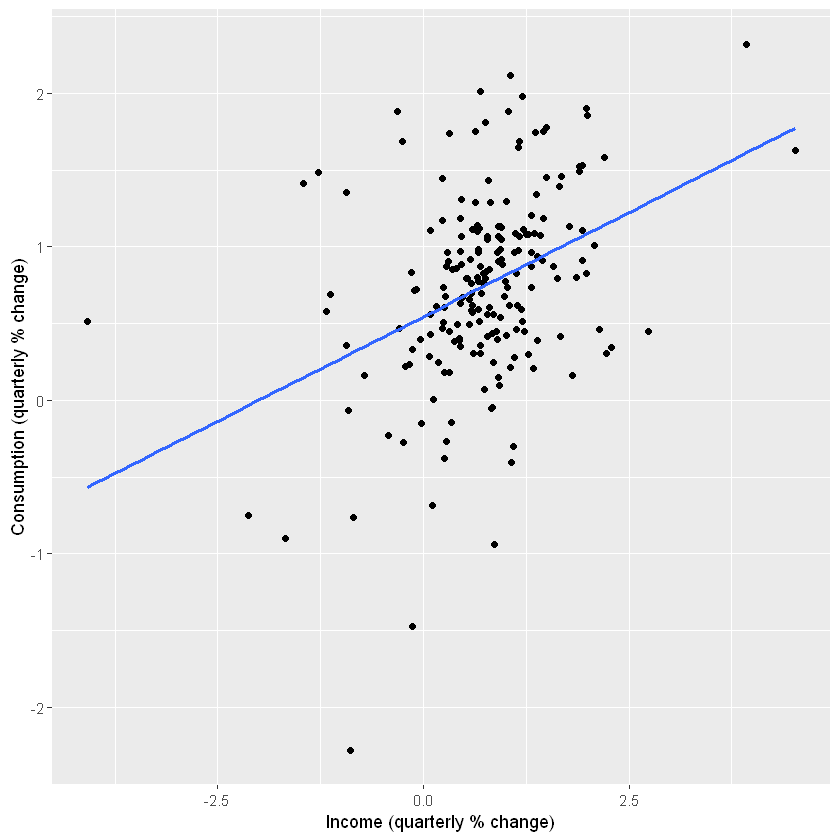

In [5]:
us_change |>
  ggplot(aes(x = Income, y = Consumption)) +
  labs(y = "Consumption (quarterly % change)",
       x = "Income (quarterly % change)") +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE)

  ggsave(paste(plot_prefix, 'consumption_income_scatter.png', sep='_'), height = 4, width =6)

In [6]:
us_change |>
  model(TSLM(Consumption ~ Income)) |>  report()

Series: Consumption 
Model: TSLM 

Residuals:
     Min       1Q   Median       3Q      Max 
-2.58236 -0.27777  0.01862  0.32330  1.42229 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.54454    0.05403  10.079  < 2e-16 ***
Income       0.27183    0.04673   5.817  2.4e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5905 on 196 degrees of freedom
Multiple R-squared: 0.1472,	Adjusted R-squared: 0.1429
F-statistic: 33.84 on 1 and 196 DF, p-value: 2.4022e-08


## Multiple Regression

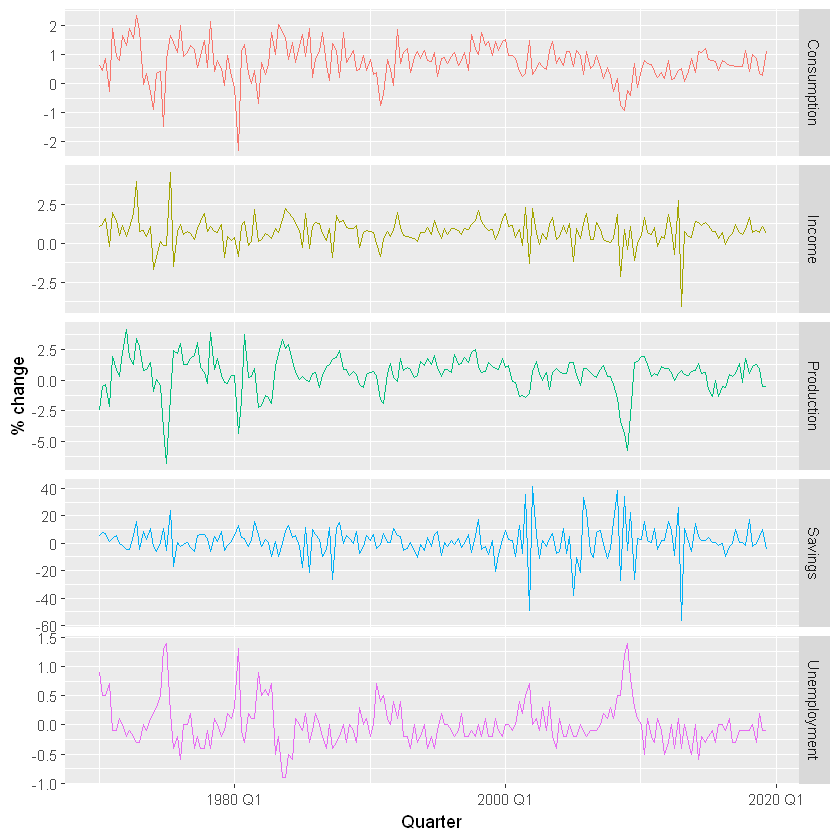

In [7]:
us_change |>
  pivot_longer(-Quarter) |>
  ggplot(aes(Quarter, value, colour = name)) +
  geom_line() +
  facet_grid(name ~ ., scales = "free_y") +
  guides(colour = "none") +
  labs(y="% change")

ggsave(paste(plot_prefix, 'con_inc_prod_savings_unemployment.png', sep='_'), height = 6, width =6)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



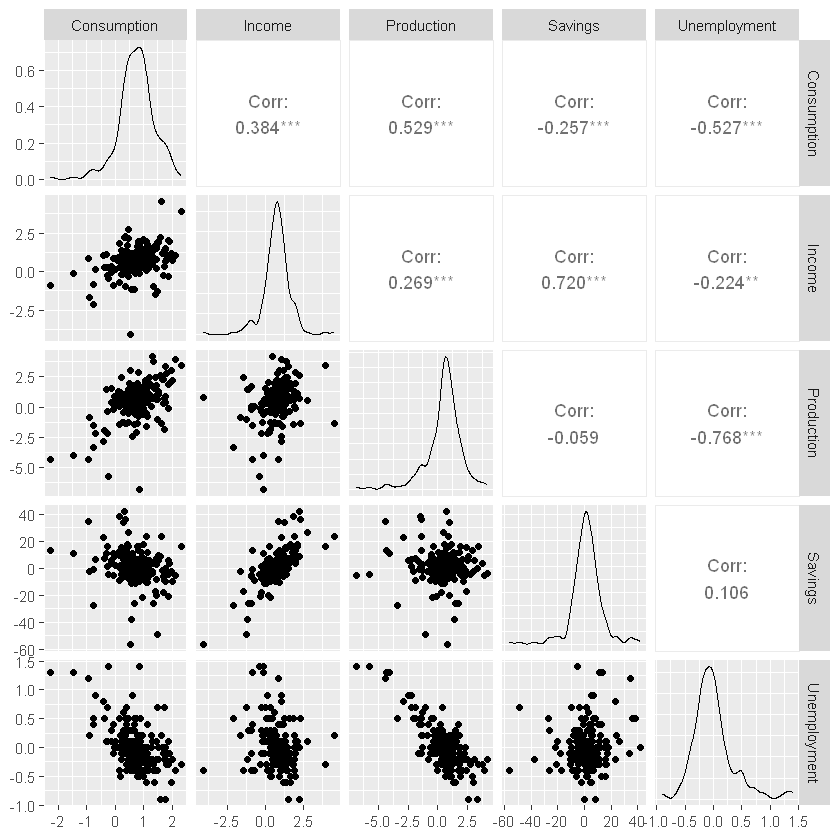

In [8]:
us_change |>
  GGally::ggpairs(columns = 2:6)

In [9]:
fit_consMR <- us_change |>
  model(tslm = TSLM(Consumption ~ Income + Production +
                                    Unemployment + Savings))
report(fit_consMR)

Series: Consumption 
Model: TSLM 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90555 -0.15821 -0.03608  0.13618  1.15471 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.253105   0.034470   7.343 5.71e-12 ***
Income        0.740583   0.040115  18.461  < 2e-16 ***
Production    0.047173   0.023142   2.038   0.0429 *  
Unemployment -0.174685   0.095511  -1.829   0.0689 .  
Savings      -0.052890   0.002924 -18.088  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3102 on 193 degrees of freedom
Multiple R-squared: 0.7683,	Adjusted R-squared: 0.7635
F-statistic:   160 on 4 and 193 DF, p-value: < 2.22e-16


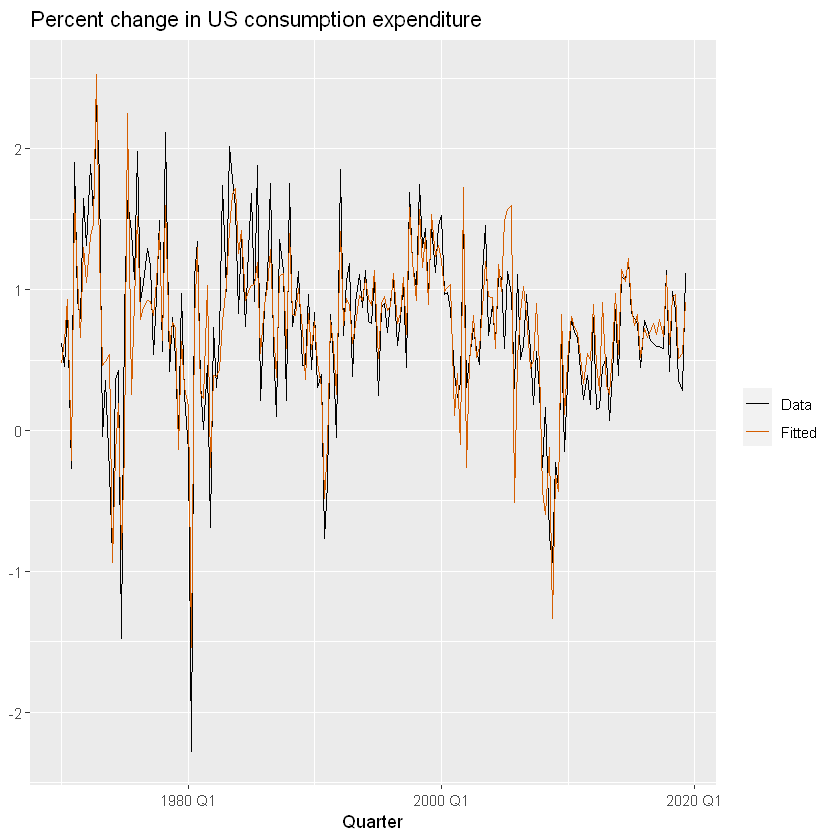

In [10]:
augment(fit_consMR) |>
  ggplot(aes(x = Quarter)) +
  geom_line(aes(y = Consumption, colour = "Data")) +
  geom_line(aes(y = .fitted, colour = "Fitted")) +
  labs(y = NULL,
    title = "Percent change in US consumption expenditure"
  ) +
  scale_colour_manual(values=c(Data="black",Fitted="#D55E00")) +
  guides(colour = guide_legend(title = NULL))

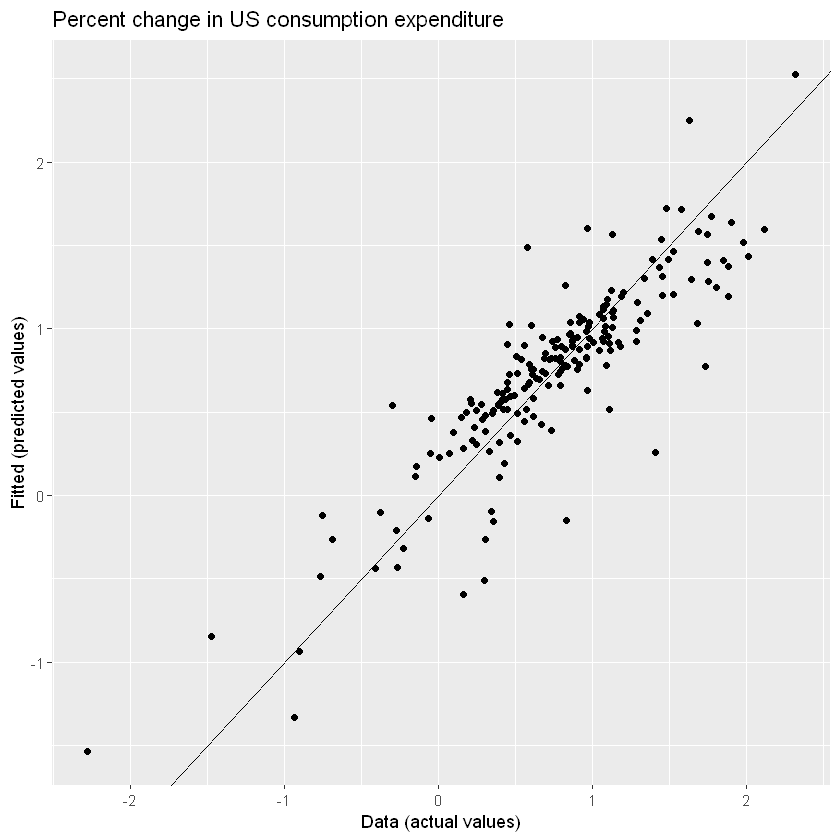

In [11]:
augment(fit_consMR) |>
  ggplot(aes(x = Consumption, y = .fitted)) +
  geom_point() +
  labs(
    y = "Fitted (predicted values)",
    x = "Data (actual values)",
    title = "Percent change in US consumption expenditure"
  ) +
  geom_abline(intercept = 0, slope = 1)

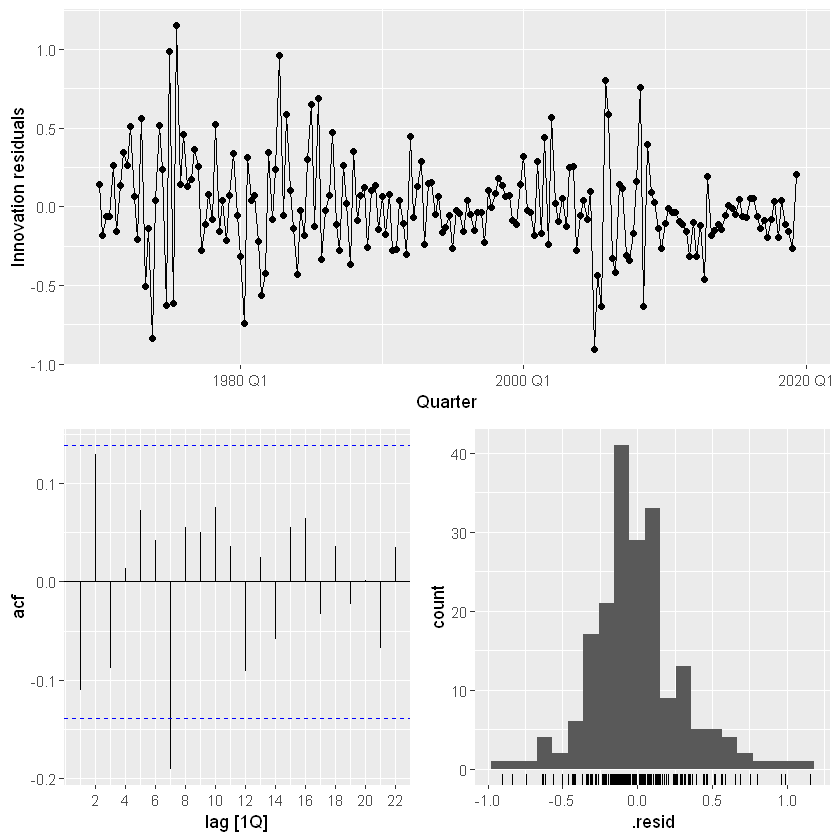

In [12]:
fit_consMR |> gg_tsresiduals()

In [13]:
augment(fit_consMR) |>
  features(.innov, ljung_box, lag = 10)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
tslm,18.86532,0.04200702


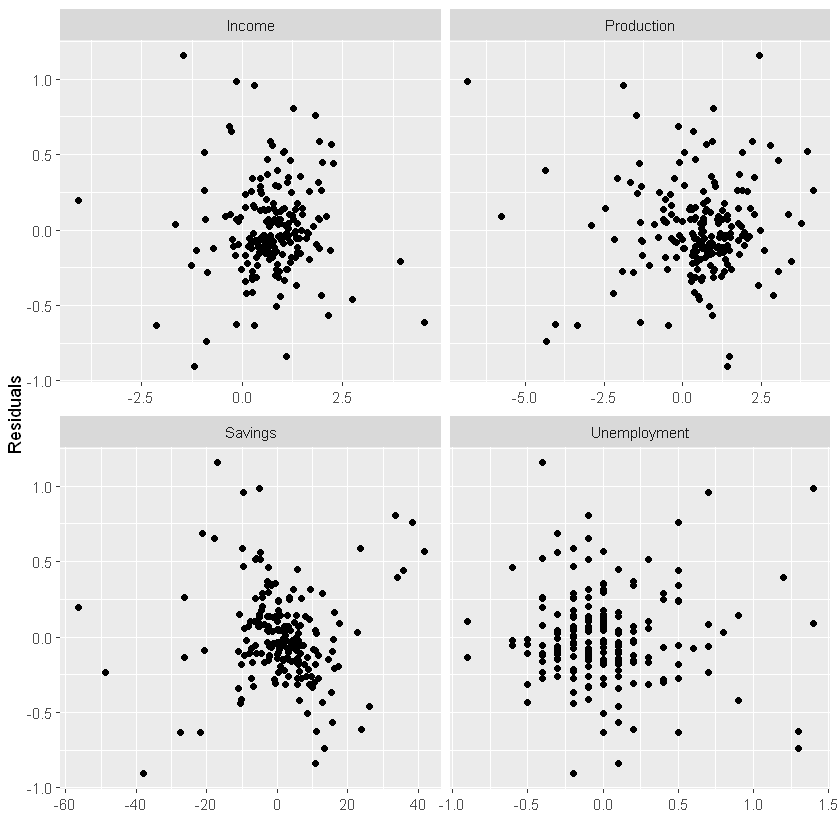

In [14]:
us_change |>
  left_join(residuals(fit_consMR), by = "Quarter") |>
  pivot_longer(Income:Unemployment,
               names_to = "regressor", values_to = "x") |>
  ggplot(aes(x = x, y = .resid)) +
  geom_point() +
  facet_wrap(. ~ regressor, scales = "free_x") +
  labs(y = "Residuals", x = "")

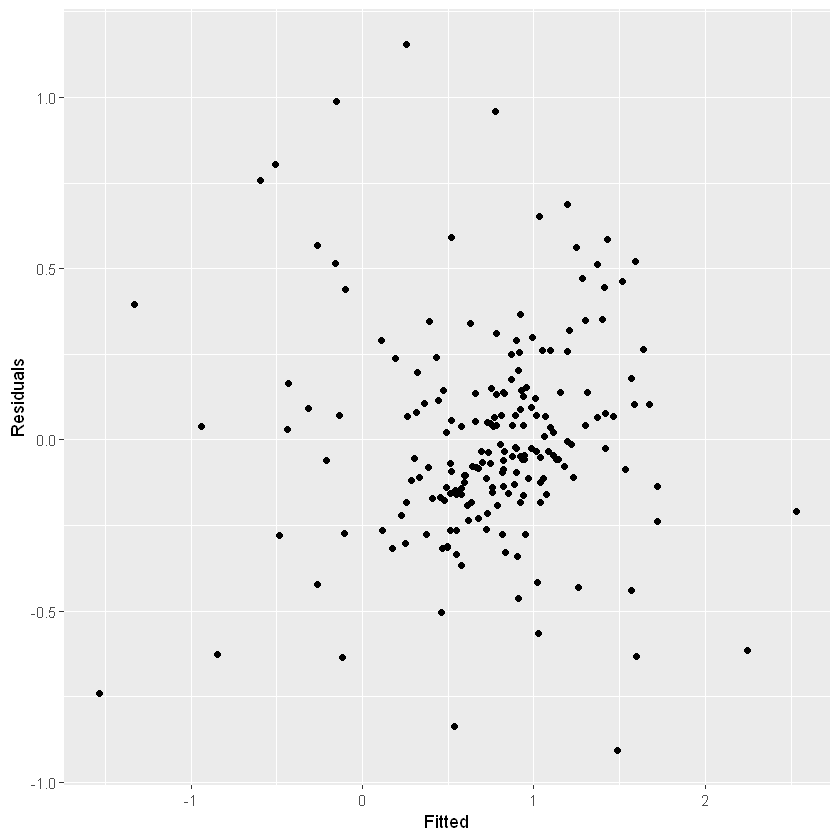

In [15]:
augment(fit_consMR) |>
  ggplot(aes(x = .fitted, y = .resid)) +
  geom_point() + labs(x = "Fitted", y = "Residuals")

In [16]:
us_change |>
model(
    'OLS' = TSLM(Consumption ~ Income),
    'Multiple Regression' = TSLM(Consumption ~ Income + Production + Unemployment + Savings)
    ) |>
report() |>
select(.model, adj_r_squared, AICc, BIC)

Warning message in report.mdl_df(model(us_change, OLS = TSLM(Consumption ~ Income), :
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,adj_r_squared,AICc,BIC
<chr>,<dbl>,<dbl>,<dbl>
OLS,0.1428848,-204.4688,-194.7277
Multiple Regression,0.7634805,-456.1401,-436.8503


## Gas Prices
Relationship between oil and driving on gas prices.

In [17]:
gas <- read.csv('data/APU000074714_AVG_PRICE_PER_GALLON_MONTHLY.csv')
miles <- read.csv('data/TRFVOLUSM227SFWA_VEHICLE_MILES.csv')
oil <- read.csv('data/WTISPLC_SPOT_CRUDE_WTI_MONTHLY.csv')

gas_demand <- gas %>% 
  left_join(miles, by='DATE') %>% 
  left_join(oil, by='DATE')
names(gas_demand) <- c('month', 'gas_price', 'miles_driven', 'oil_price')

# These start are various times, so setting to a common origin
# yearmonth tells what the frequency is, will try to detect otherwise
gas_demand <- gas_demand[complete.cases(gas_demand),] %>%
  mutate(month = yearmonth(as.Date(month))) %>% as_tsibble(index='month',)

gas_demand <- gas_demand %>%
  mutate(gas_price_pct = gas_price/lag(gas_price) - 1,
         miles_driven_pct = miles_driven/lag(miles_driven)-1,
         oil_price_pct = oil_price/lag(oil_price)-1
         )

gas_demand %>% head()

month,gas_price,miles_driven,oil_price,gas_price_pct,miles_driven_pct,oil_price_pct
<mth>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000 Jan,1.301,227235,27.18,NA,NA,NA
2000 Feb,1.369,228727,29.35,0.052267487,0.006565890,0.07983812
2000 Mar,1.541,230237,29.89,0.125639153,0.006601757,0.01839864
2000 Apr,1.506,229068,25.74,-0.022712524,-0.005077377,-0.13884242
2000 May,1.498,229651,28.78,-0.005312085,0.002545096,0.11810412
2000 Jun,1.617,230024,31.83,0.079439252,0.001624204,0.10597637


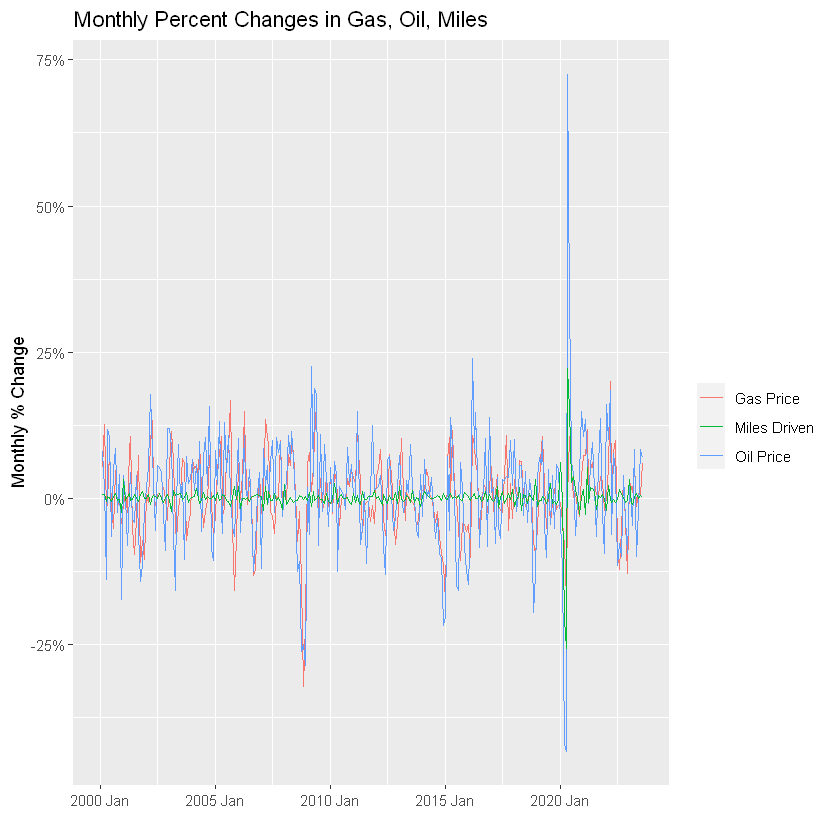

In [18]:
gas_plot <- ggplot() + 
  geom_line(data=gas_demand, aes(x=month, y=gas_price_pct, colour='Gas Price'), na.rm = TRUE) +
  geom_line(data=gas_demand, aes(x=month, y=oil_price_pct, colour='Oil Price'), na.rm = TRUE) +
  geom_line(data=gas_demand, aes(x=month, y=miles_driven_pct, colour='Miles Driven'), na.rm = TRUE) +
  labs(title='Monthly Percent Changes in Gas, Oil, Miles', y='Monthly % Change', x='') +
  guides(colour = guide_legend(title = "")) +
  scale_y_continuous(labels = scales::percent)

gas_plot
ggsave(paste(plot_prefix, 'oil_gas_miles.png'), height=3, width=5)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


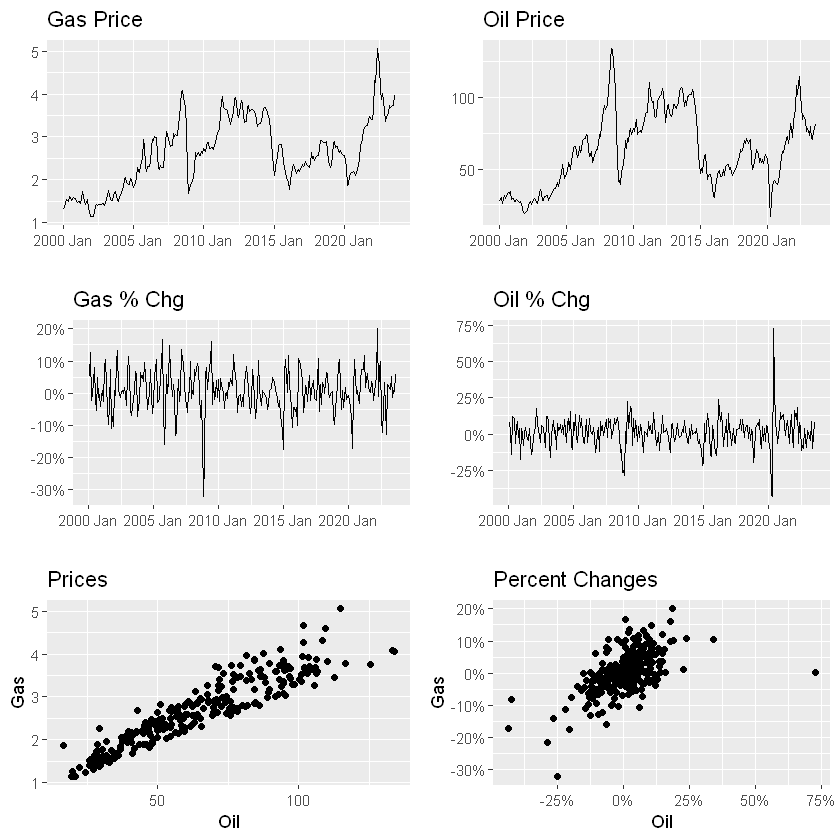

In [19]:
gas_ts_plot <- autoplot(gas_demand, gas_price) + labs(title='Gas Price', x='', y='')
oil_ts_plot <- autoplot(gas_demand, oil_price) + labs(title='Oil Price', x='', y='')
gas_chg_ts_plot <- autoplot(gas_demand, gas_price_pct) + labs(title='Gas % Chg', x='', y='') + scale_y_continuous(labels = scales::percent)
oil_chg_ts_plot <- autoplot(gas_demand, oil_price_pct) + labs(title='Oil % Chg', x='', y='') + scale_y_continuous(labels = scales::percent)
gas_oil_scat <- ggplot(data=gas_demand, aes(x=oil_price, y=gas_price)) + geom_point(na.rm = TRUE) + labs(title='Prices', x='Oil', y='Gas')
gas_oil_chg_scat <- ggplot(data=gas_demand, aes(x=oil_price_pct, y=gas_price_pct)) + geom_point(na.rm = TRUE) + labs(title='Percent Changes', x='Oil', y='Gas') + scale_y_continuous(labels = scales::percent)+ scale_x_continuous(labels = scales::percent)

comb <- arrangeGrob(gas_ts_plot, oil_ts_plot, gas_chg_ts_plot, oil_chg_ts_plot, gas_oil_scat, gas_oil_chg_scat,ncol=2)
ggsave(paste(plot_prefix, 'oil_gas_plots.png',sep='_'), plot=comb, height = 6, width=6)
comb %>% plot()

## Time Series Linear Regression

In [20]:
gas_models <- gas_demand %>%
  model('Only Oil' = TSLM(gas_price_pct ~ oil_price_pct),
        'Only Miles' = TSLM(gas_price_pct ~ miles_driven_pct),
        'Oil and Miles' = TSLM(gas_price_pct ~ oil_price_pct + miles_driven_pct))

gas_models %>% report()

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,r_squared,adj_r_squared,sigma2,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Only Oil,0.32955251,0.32716658,0.002831514,138.123056,3.306891e-26,2,429.6165,-1656.352,-1656.266,-1645.416,0.002972752,0.7956554,281,2
Only Miles,0.01999635,0.01650879,0.004138869,5.733627,1.729842e-02,2,375.9015,-1548.922,-1548.836,-1537.986,0.004194110,1.1630221,281,2
Oil and Miles,0.36015636,0.35558605,0.002711915,78.803458,7.084996e-28,3,436.2276,-1667.574,-1667.430,-1652.993,0.002916841,0.7593362,280,3


In [21]:
gas_models %>% select(.model = 'Only Oil') %>% report()

Series: gas_price_pct 
Model: TSLM 

Residuals:
      Min        1Q    Median        3Q       Max 
-0.264315 -0.030340  0.001355  0.029242  0.161885 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.002763   0.003176    0.87    0.385    
oil_price_pct 0.362628   0.030855   11.75   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05321 on 281 degrees of freedom
Multiple R-squared: 0.3296,	Adjusted R-squared: 0.3272
F-statistic: 138.1 on 1 and 281 DF, p-value: < 2.22e-16


In [22]:
gas_oil_model <- gas_models %>% select(.model = 'Only Oil')

gas_oil_fit_plot <- gas_oil_model  %>% report() %>% augment() %>% ggplot(aes(x=month)) +
  geom_line(aes(y=gas_price_pct, colour='Data'), na.rm = TRUE) +
  geom_line(aes(y=.fitted, colour='Fitted'), na.rm = TRUE) +
  labs(y=NULL, title='Percent Change in Gas Prices', x=NULL) +
  scale_y_continuous(labels=scales::percent) +
  guides(colour=guide_legend(title=NULL))

ggsave(paste(plot_prefix, 'gas_oil_fit.png', sep='_'), height = 3, width = 5)

Series: gas_price_pct 
Model: TSLM 

Residuals:
      Min        1Q    Median        3Q       Max 
-0.264315 -0.030340  0.001355  0.029242  0.161885 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.002763   0.003176    0.87    0.385    
oil_price_pct 0.362628   0.030855   11.75   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05321 on 281 degrees of freedom
Multiple R-squared: 0.3296,	Adjusted R-squared: 0.3272
F-statistic: 138.1 on 1 and 281 DF, p-value: < 2.22e-16


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."


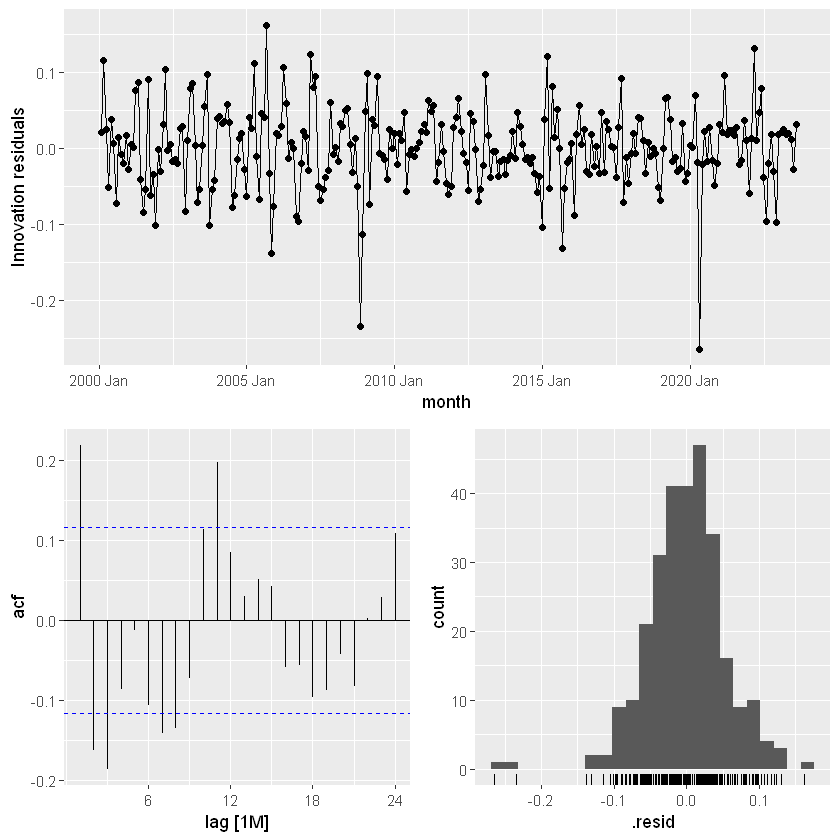

In [23]:
gas_oil_model %>% gg_tsresiduals()
ggsave(paste(plot_prefix, 'oil_gas_residuals.png'), height = 5, width = 5)

Gas, Oil, and Miles

In [24]:
gas_models %>% select(.model = 'Oil and Miles') %>% report()

Series: gas_price_pct 
Model: TSLM 

Residuals:
      Min        1Q    Median        3Q       Max 
-0.218568 -0.028912  0.001712  0.030792  0.154419 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.002654   0.003108   0.854 0.393953    
oil_price_pct     0.427920   0.035074  12.201  < 2e-16 ***
miles_driven_pct -0.478058   0.130632  -3.660 0.000302 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05208 on 280 degrees of freedom
Multiple R-squared: 0.3602,	Adjusted R-squared: 0.3556
F-statistic:  78.8 on 2 and 280 DF, p-value: < 2.22e-16


Including Trend and Seasonal Factors

In [25]:
gas_models <- gas_demand %>%
  model('Only Oil' = TSLM(gas_price_pct ~ oil_price_pct),
        'Only Miles' = TSLM(gas_price_pct ~ miles_driven_pct),
        'Oil and Miles' = TSLM(gas_price_pct ~ oil_price_pct + miles_driven_pct),
        'Oil and Miles and Seasonal' = TSLM(gas_price_pct ~ oil_price_pct + miles_driven_pct + season()),
        'Oil and Miles and Trend' = TSLM(gas_price_pct ~ oil_price_pct + miles_driven_pct + trend()),
        'Oil and Miles and Fourier' = TSLM(gas_price_pct ~ oil_price_pct + miles_driven + fourier(K=2)),
        'Oil and Miles and Dist-Lag' = TSLM(gas_price_pct ~ oil_price_pct + miles_driven + lag(gas_price_pct, 1) + lag(gas_price_pct, 2)),
                'Oil, Miles, Dist-Lag, and Fourier' = TSLM(gas_price_pct ~ oil_price_pct + miles_driven + lag(gas_price_pct, 1) + lag(gas_price_pct, 2) + fourier(K=2))
  )

gas_models %>% report() %>% select(.model, adj_r_squared, AICc, BIC) %>% filter(.model %in% c('Only Oil', 'Oil and Miles'))

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,adj_r_squared,AICc,BIC
<chr>,<dbl>,<dbl>,<dbl>
Only Oil,0.3271666,-1656.266,-1645.416
Oil and Miles,0.3555861,-1667.430,-1652.993


Seasonality

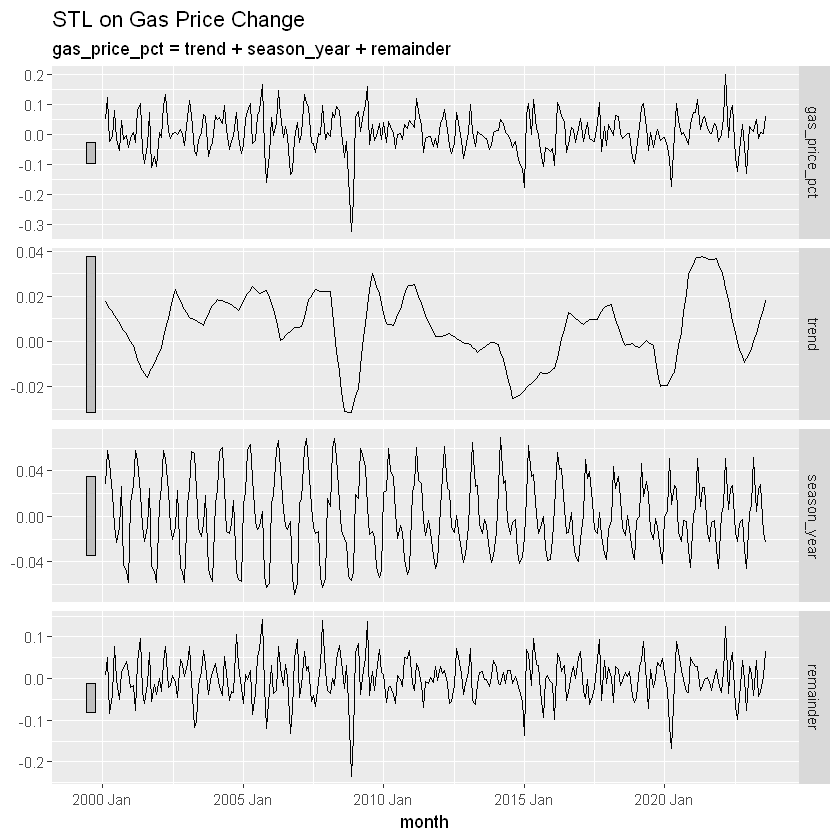

In [26]:
gas_stl <- gas_demand %>% drop_na() %>% model(STL = STL(gas_price_pct))
components(gas_stl) %>% autoplot() + labs(title = 'STL on Gas Price Change')
ggsave(paste(plot_prefix, 'gas_stl.png', sep='_'), height = 3, width = 4)

In [27]:
gas_models %>% report() %>% select(.model, adj_r_squared, AICc, BIC)

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,adj_r_squared,AICc,BIC
<chr>,<dbl>,<dbl>,<dbl>
Only Oil,0.32716658,-1656.266,-1645.416
Only Miles,0.01650879,-1548.836,-1537.986
Oil and Miles,0.35558605,-1667.430,-1652.993
Oil and Miles and Seasonal,0.46771571,-1709.218,-1656.334
Oil and Miles and Trend,0.35355819,-1665.481,-1647.471
Oil and Miles and Fourier,0.46341647,-1714.944,-1686.306
Oil and Miles and Dist-Lag,0.49999257,-1726.711,-1705.187
"Oil, Miles, Dist-Lag, and Fourier",0.55846583,-1757.252,-1721.683


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."


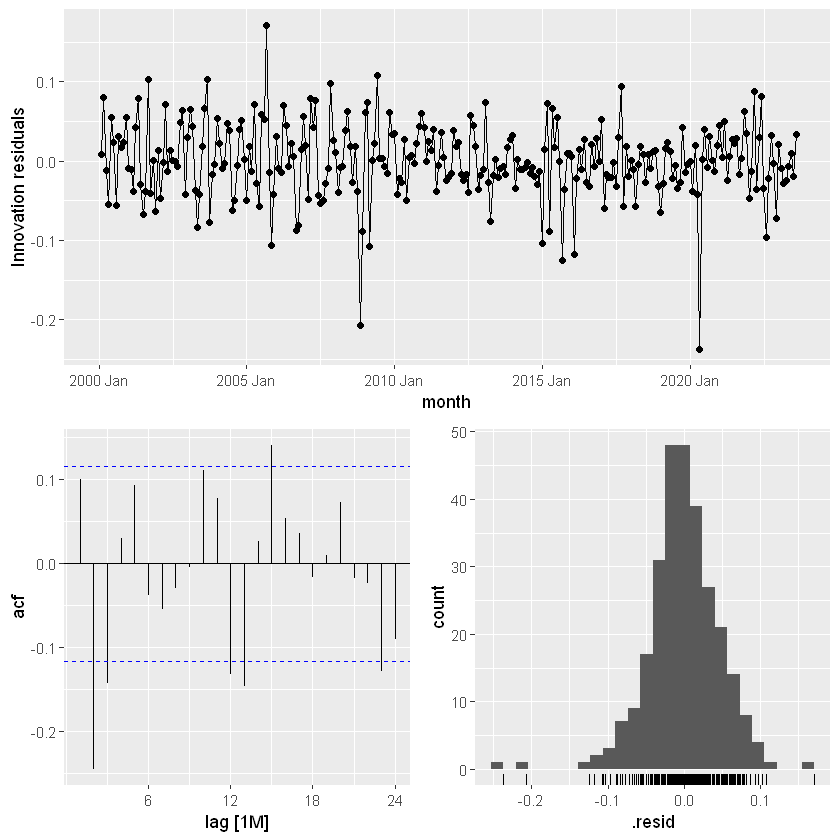

In [28]:
gas_models %>% select(.model = 'Oil and Miles and Fourier') %>% gg_tsresiduals()

Series: gas_price_pct 
Model: TSLM 

Residuals:
      Min        1Q    Median        3Q       Max 
-0.237210 -0.024879 -0.001081  0.027396  0.171175 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -8.962e-02  5.416e-02  -1.655  0.09912 .  
oil_price_pct        3.265e-01  2.801e-02  11.657  < 2e-16 ***
miles_driven         3.669e-07  2.149e-07   1.707  0.08887 .  
fourier(K = 2)C1_12  8.030e-04  3.997e-03   0.201  0.84091    
fourier(K = 2)S1_12  2.940e-02  4.069e-03   7.226 4.88e-12 ***
fourier(K = 2)C2_12 -1.058e-02  4.007e-03  -2.640  0.00876 ** 
fourier(K = 2)S2_12  1.595e-02  3.993e-03   3.995 8.30e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04752 on 276 degrees of freedom
Multiple R-squared: 0.4748,	Adjusted R-squared: 0.4634
F-statistic: 41.59 on 6 and 276 DF, p-value: < 2.22e-16


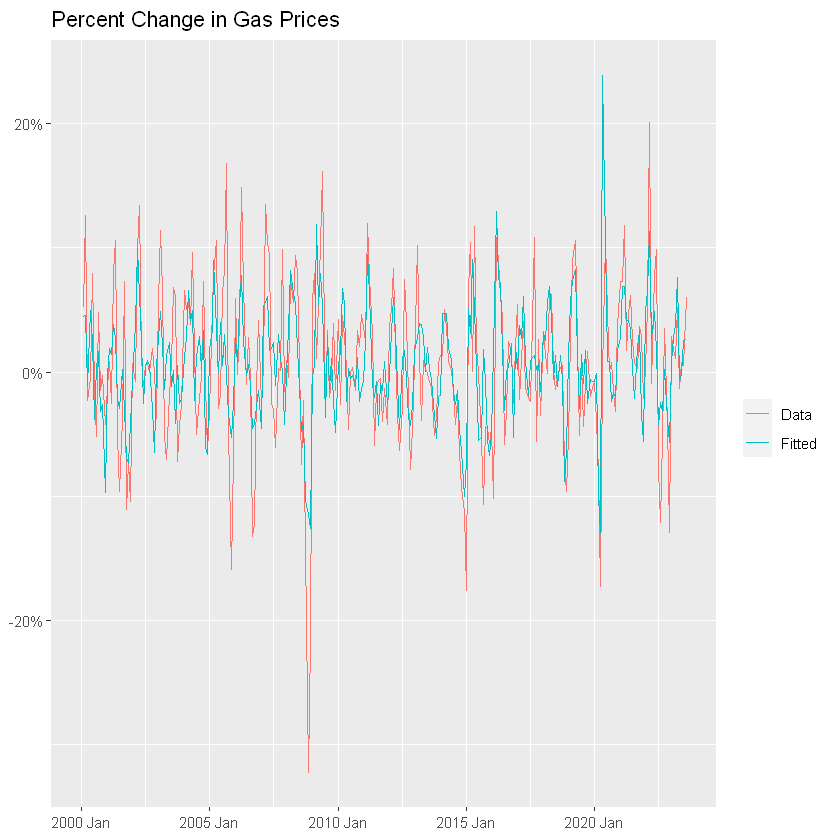

In [29]:
gas_oil_fourier_plot <- gas_models %>%  select(.model = 'Oil and Miles and Fourier')  %>% report() %>% augment() %>% ggplot(aes(x=month)) +
  geom_line(aes(y=gas_price_pct, colour='Data'), na.rm = TRUE) +
  geom_line(aes(y=.fitted, colour='Fitted'), na.rm = TRUE) +
  labs(y=NULL, title='Percent Change in Gas Prices', x=NULL) +
  scale_y_continuous(labels=scales::percent) +
  guides(colour=guide_legend(title=NULL))

gas_oil_fourier_plot
ggsave(paste(plot_prefix, 'gas_oil_fourier_fit.png', sep='_'), height = 3, width = 5)

Distributed Lags on Gas Price

Series: gas_price_pct 
Model: TSLM 

Residuals:
      Min        1Q    Median        3Q       Max 
-0.184256 -0.025006 -0.001565  0.026081  0.153396 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -7.499e-02  4.973e-02  -1.508  0.13269    
oil_price_pct          3.253e-01  2.540e-02  12.807  < 2e-16 ***
miles_driven           3.040e-07  1.973e-07   1.541  0.12449    
lag(gas_price_pct, 1)  3.573e-01  4.664e-02   7.660 3.28e-13 ***
lag(gas_price_pct, 2) -1.865e-01  4.659e-02  -4.004 8.05e-05 ***
fourier(K = 2)C1_12    1.323e-03  3.942e-03   0.336  0.73738    
fourier(K = 2)S1_12    2.087e-02  3.990e-03   5.231 3.37e-07 ***
fourier(K = 2)C2_12   -5.205e-03  3.739e-03  -1.392  0.16495    
fourier(K = 2)S2_12    1.233e-02  3.711e-03   3.324  0.00101 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04296 on 272 degrees of freedom
Multiple R-squared: 0.5711,	Adjusted R-squared: 0.5585
F-s

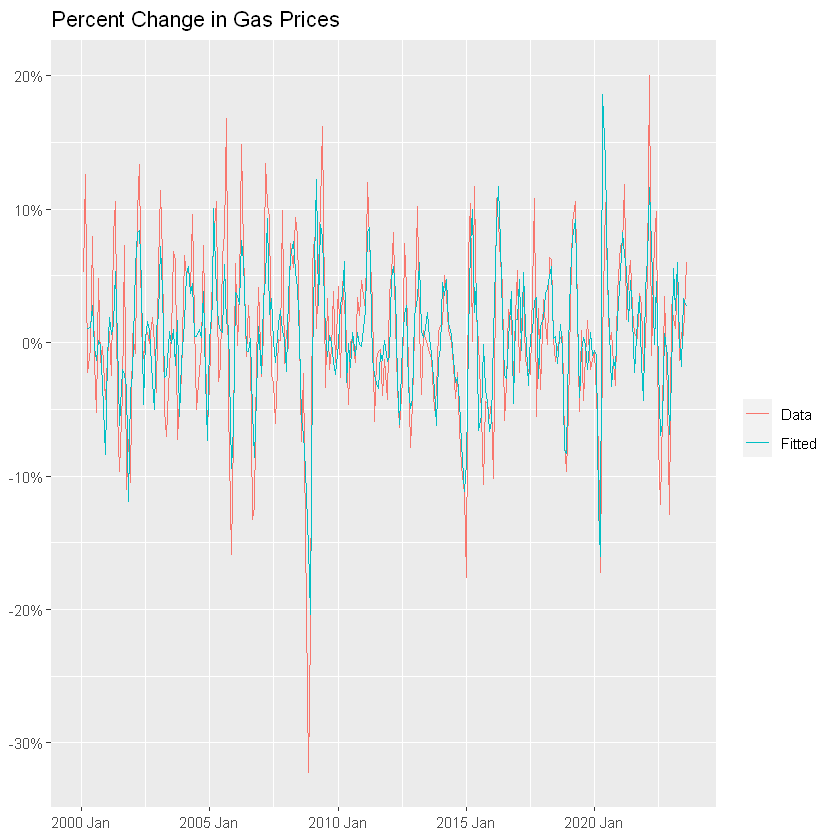

In [30]:
gas_oil_dlag_fourier_plot <- gas_models %>%  select(.model = 'Oil, Miles, Dist-Lag, and Fourier')  %>% report() %>% augment() %>% ggplot(aes(x=month)) +
  geom_line(aes(y=gas_price_pct, colour='Data'), na.rm = TRUE) +
  geom_line(aes(y=.fitted, colour='Fitted'), na.rm = TRUE) +
  labs(y=NULL, title='Percent Change in Gas Prices', x=NULL) +
  scale_y_continuous(labels=scales::percent) +
  guides(colour=guide_legend(title=NULL))

gas_oil_dlag_fourier_plot
ggsave(paste(plot_prefix, 'gas_oil_dlag_fourier_fit.png', sep='_'), height = 3, width = 5)

Warning message:
"Removed 3 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 3 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 3 rows containing non-finite values (`stat_bin()`)."


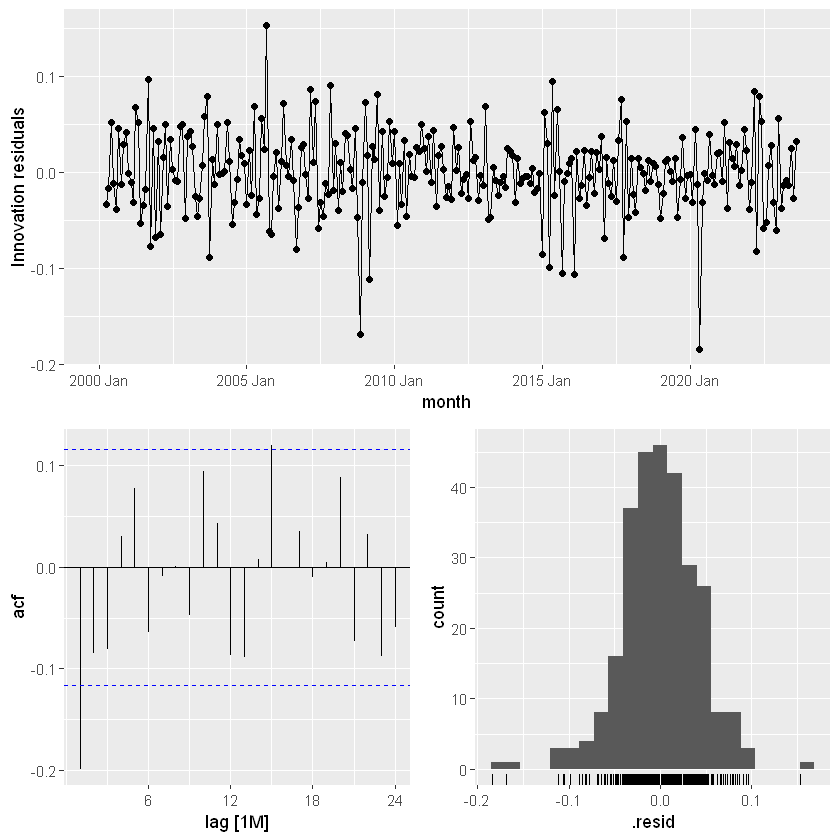

In [31]:
gas_models %>% select(.model = 'Oil, Miles, Dist-Lag, and Fourier') %>% gg_tsresiduals()

In [32]:
gas_models %>% select(.model = 'Oil, Miles, Dist-Lag, and Fourier') %>% report() %>% glance()

Series: gas_price_pct 
Model: TSLM 

Residuals:
      Min        1Q    Median        3Q       Max 
-0.184256 -0.025006 -0.001565  0.026081  0.153396 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -7.499e-02  4.973e-02  -1.508  0.13269    
oil_price_pct          3.253e-01  2.540e-02  12.807  < 2e-16 ***
miles_driven           3.040e-07  1.973e-07   1.541  0.12449    
lag(gas_price_pct, 1)  3.573e-01  4.664e-02   7.660 3.28e-13 ***
lag(gas_price_pct, 2) -1.865e-01  4.659e-02  -4.004 8.05e-05 ***
fourier(K = 2)C1_12    1.323e-03  3.942e-03   0.336  0.73738    
fourier(K = 2)S1_12    2.087e-02  3.990e-03   5.231 3.37e-07 ***
fourier(K = 2)C2_12   -5.205e-03  3.739e-03  -1.392  0.16495    
fourier(K = 2)S2_12    1.233e-02  3.711e-03   3.324  0.00101 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04296 on 272 degrees of freedom
Multiple R-squared: 0.5711,	Adjusted R-squared: 0.5585
F-s

.model,r_squared,adj_r_squared,sigma2,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
.model,0.5710811,0.5584658,0.001845348,45.26906,8.351118e-46,9,490.3117,-1758.067,-1757.252,-1721.683,0.002015998,0.5019348,272,9


## Yuan-Dollar Exchange Rate
Time series data may have structural breaks, regime changes

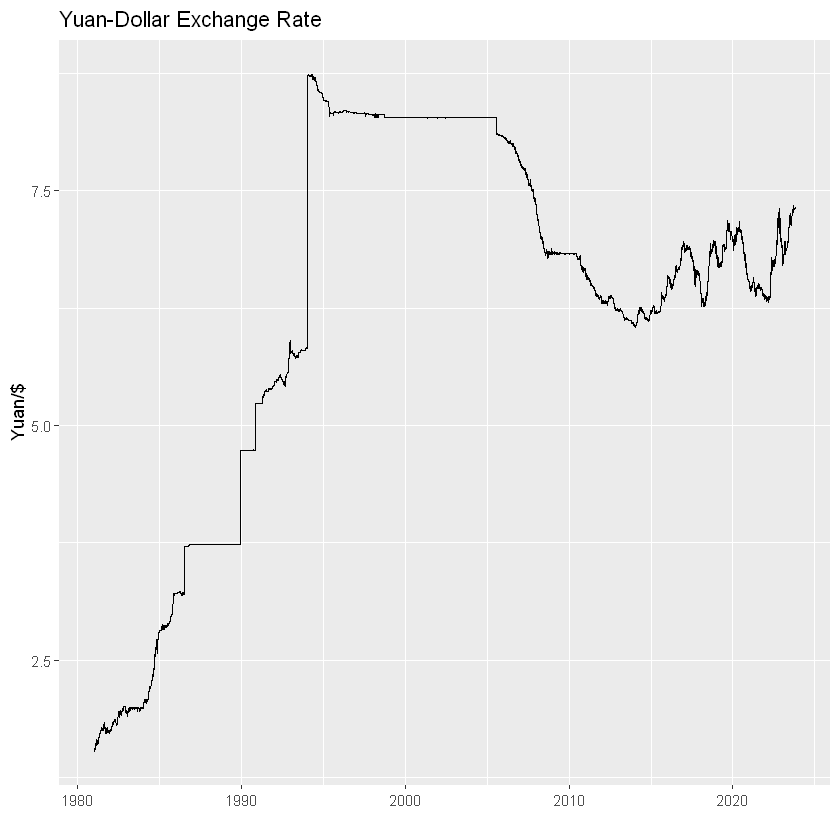

In [33]:
yuan_exchange <- read.csv('data/DEXCHUS_YUAN_DOLLAR_EXCHANGE_RATE.csv', col.names=c('day', 'yuan_dollar')) %>%
  mutate(day = as.Date(day)) %>%
  filter(yuan_dollar != '.') %>%
  mutate(yuan_dollar = as.numeric(yuan_dollar)) %>%
  as_tsibble(index='day') %>%
  fill_gaps() %>%
  tidyr::fill(yuan_dollar, .direction = 'up')

yuan_exchange %>%
  autoplot(yuan_dollar) +
  labs(title='Yuan-Dollar Exchange Rate', y='Yuan/$', x='')

ggsave(paste(plot_prefix, 'yuan_dollar_plot.png', sep='_'), height = 3, width=5)

Level shift, caused by policy changes, great candidate for intervention (i.e., dummy variables).

In [34]:
yuan_exchange <- yuan_exchange %>% mutate(chg = difference(yuan_dollar))
yuan_exchange %>% arrange(desc(chg)) %>% head()

Warning message:
"Current temporal ordering may yield unexpected results.
ℹ Suggest to sort by ``, `day` first."


Warning message:
"Current temporal ordering may yield unexpected results.
ℹ Suggest to sort by ``, `day` first."


day,yuan_dollar,chg
<date>,<dbl>,<dbl>
1994-01-01,8.7217,2.9072
1989-12-16,4.7339,1.0025
1986-07-04,3.7129,0.5066
1990-11-16,5.2352,0.5013
2015-08-11,6.3232,0.1138
2019-08-03,7.0481,0.1094


In [35]:
yuan_exchange <- yuan_exchange %>%
  mutate(intervention1 = ifelse(day >= as.Date('1994-01-03'), 1, 0),
         intervention2 = ifelse(day >= as.Date('1989-12-18'), 1, 0),
         intervention3 = ifelse(day >= as.Date('1990-11-19'), 1, 0),
         intervention4 = ifelse(day >= as.Date('1986-07-07'), 1, 0),
         lag1 = lag(yuan_dollar, 1),
         lag2 = lag(yuan_dollar, 2)
         )

yuan_models <- yuan_exchange %>%
  model('Dist-Lag' = TSLM(yuan_dollar ~ trend() + lag1 + lag2),
        'Dist-Lag and Interventions' = TSLM(yuan_dollar ~ trend() + lag1 + lag2 + intervention1 + intervention2 + intervention3 + intervention4),
        'Trend and Interventions' = TSLM(yuan_dollar ~ trend()+ intervention1 + intervention2 + intervention3 + intervention4),
        'Trend' =  TSLM(yuan_dollar ~ trend()))

yuan_models %>% report()

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,r_squared,adj_r_squared,sigma2,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Dist-Lag,0.9998270,0.9998270,0.0007046633,30128014.523,0,4,34574.56,-113534.87,-113534.87,-113496.58,0.0007046630,11.02093,15640,4
Dist-Lag and Interventions,0.9998272,0.9998271,0.0007041527,12921371.322,0,8,34582.23,-113542.22,-113542.20,-113473.29,0.0007050909,11.01013,15636,8
Trend and Interventions,0.9483225,0.9483060,0.2106270999,57401.293,0,6,-10012.09,-24363.24,-24363.24,-24309.64,0.2106627867,3294.20784,15640,6
Trend,0.3254639,0.3254207,2.7485729276,7548.234,0,2,-30109.41,15823.39,15823.39,15846.36,2.7489093038,42998.67488,15644,2


Series: yuan_dollar 
Model: TSLM 

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7198 -1.2130 -0.5768  1.8245  3.2708 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.244e+00  2.651e-02  160.11   <2e-16 ***
trend()     2.550e-04  2.935e-06   86.88   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.658 on 15644 degrees of freedom
Multiple R-squared: 0.3255,	Adjusted R-squared: 0.3254
F-statistic:  7548 on 1 and 15644 DF, p-value: < 2.22e-16


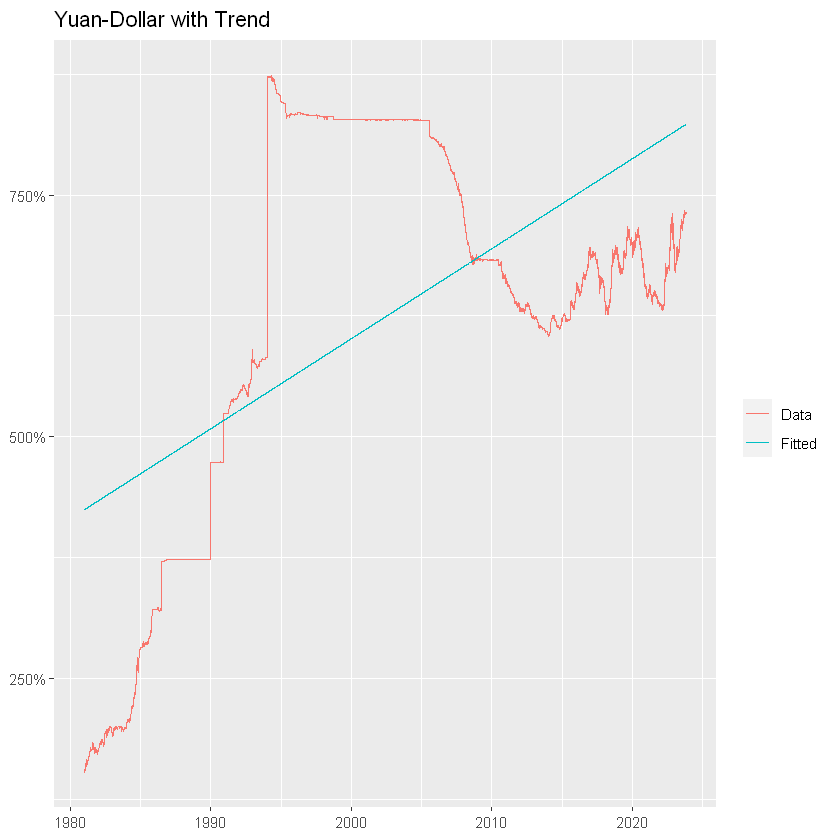

In [36]:
yuan_models %>%  select(.model = 'Trend')  %>% report() %>% augment() %>% ggplot(aes(x=day)) +
  geom_line(aes(y=yuan_dollar, colour='Data'), na.rm = TRUE) +
  geom_line(aes(y=.fitted, colour='Fitted'), na.rm = TRUE) +
  labs(y=NULL, title='Yuan-Dollar with Trend', x=NULL) +
  scale_y_continuous(labels=scales::percent) +
  guides(colour=guide_legend(title=NULL))

ggsave(paste(plot_prefix, 'yuan_trend.png'), height=3, width=5)

Series: yuan_dollar 
Model: TSLM 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.96628 -0.32006  0.02942  0.31443  3.30702 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.494e+00  1.033e-02  241.48   <2e-16 ***
trend()       -2.213e-04  1.391e-06 -159.06   <2e-16 ***
intervention1  3.172e+00  1.655e-02  191.62   <2e-16 ***
intervention2  1.183e+00  2.820e-02   41.96   <2e-16 ***
intervention3  9.659e-01  2.850e-02   33.88   <2e-16 ***
intervention4  1.823e+00  1.664e-02  109.51   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4589 on 15640 degrees of freedom
Multiple R-squared: 0.9483,	Adjusted R-squared: 0.9483
F-statistic: 5.74e+04 on 5 and 15640 DF, p-value: < 2.22e-16


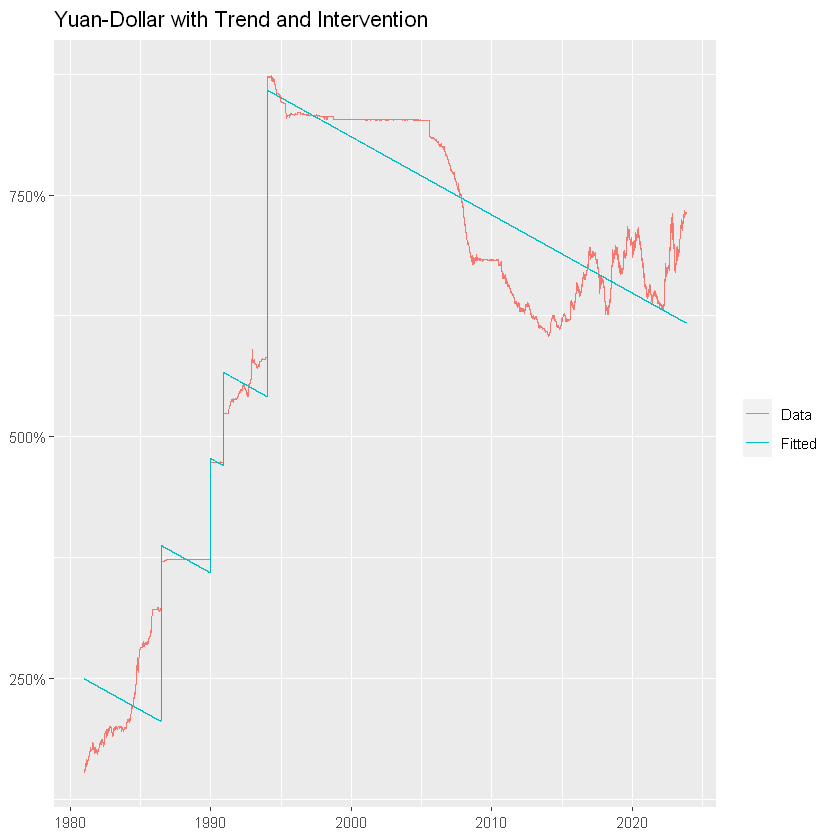

In [37]:
yuan_models %>%  select(.model = 'Trend and Interventions')  %>% report() %>% augment() %>% ggplot(aes(x=day)) +
  geom_line(aes(y=yuan_dollar, colour='Data'), na.rm = TRUE) +
  geom_line(aes(y=.fitted, colour='Fitted'), na.rm = TRUE) +
  labs(y=NULL, title='Yuan-Dollar with Trend and Intervention', x=NULL) +
  scale_y_continuous(labels=scales::percent) +
  guides(colour=guide_legend(title=NULL))

ggsave(paste(plot_prefix, 'yuan_trend_intervention.png'), height=3, width=5)

### Nonlinear Regression

In [38]:
yuan_models_non <- yuan_exchange %>%
  model('Dist-Lag' = TSLM(yuan_dollar ~ trend() + lag1 + lag2),
        'Dist-Lag and Interventions' = TSLM(yuan_dollar ~ trend() + lag1 + lag2 + intervention1 + intervention2 + intervention3 + intervention4),
        'Trend and Interventions' = TSLM(yuan_dollar ~ trend()+ intervention1 + intervention2 + intervention3 + intervention4),
        'Trend' =  TSLM(yuan_dollar ~ trend()),
        'Exponential' = TSLM(log(yuan_dollar) ~ trend()),
        'Exponential and Intervention' = TSLM(log(yuan_dollar) ~ trend()+ intervention1 + intervention2 + intervention3 + intervention4),
        'Piecewise Trend' = TSLM(yuan_dollar ~ trend(knots = c(as.Date('1986-07-07'), as.Date('1989-12-18'),as.Date('1990-11-19'), as.Date('1993-01-03')))),
        'Piecewise Trend Lags' = TSLM(yuan_dollar ~ lag1 + lag2 + trend(knots = c(as.Date('1986-07-07'), as.Date('1989-12-18'),as.Date('1990-11-19'), as.Date('1993-01-03'))))
    
        )

yuan_models_non %>% report()

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,r_squared,adj_r_squared,sigma2,statistic,p_value,df,log_lik,AIC,AICc,BIC,CV,deviance,df.residual,rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Dist-Lag,0.9998270,0.9998270,0.0007046633,30128014.523,0,4,34574.563,-113534.87,-113534.87,-113496.58,0.0007046630,11.02093,15640,4
Dist-Lag and Interventions,0.9998272,0.9998271,0.0007041527,12921371.322,0,8,34582.233,-113542.22,-113542.20,-113473.29,0.0007050909,11.01013,15636,8
Trend and Interventions,0.9483225,0.9483060,0.2106270999,57401.293,0,6,-10012.091,-24363.24,-24363.24,-24309.64,0.2106627867,3294.20784,15640,6
Trend,0.3254639,0.3254207,2.7485729276,7548.234,0,2,-30109.405,15823.39,15823.39,15846.36,2.7489093038,42998.67488,15644,2
Exponential,0.4034306,0.4033925,0.1135520818,10579.269,0,2,-5180.825,-34033.77,-34033.77,-34010.80,0.1135706164,1776.40877,15644,2
Exponential and Intervention,0.9446142,0.9445965,0.0105449224,53348.599,0,6,13413.451,-71214.33,-71214.32,-71160.72,0.0105495711,164.92259,15640,6
Piecewise Trend,0.8965605,0.8965274,0.4215990324,27111.892,0,6,-15440.982,-13505.46,-13505.45,-13451.85,0.4216853378,6593.80887,15640,6
Piecewise Trend Lags,0.9998271,0.9998271,0.0007042474,12919632.941,0,8,34581.181,-113540.11,-113540.10,-113471.19,0.0007055265,11.01161,15636,8


Series: yuan_dollar 
Model: TSLM 
Transformation: log(yuan_dollar) 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39976 -0.05945  0.00484  0.04708  0.54567 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    8.228e-01  2.311e-03  356.09   <2e-16 ***
trend()       -2.817e-05  3.113e-07  -90.48   <2e-16 ***
intervention1  4.504e-01  3.704e-03  121.59   <2e-16 ***
intervention2  2.613e-01  6.310e-03   41.42   <2e-16 ***
intervention3  1.764e-01  6.378e-03   27.66   <2e-16 ***
intervention4  5.684e-01  3.724e-03  152.63   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1027 on 15640 degrees of freedom
Multiple R-squared: 0.9446,	Adjusted R-squared: 0.9446
F-statistic: 5.335e+04 on 5 and 15640 DF, p-value: < 2.22e-16


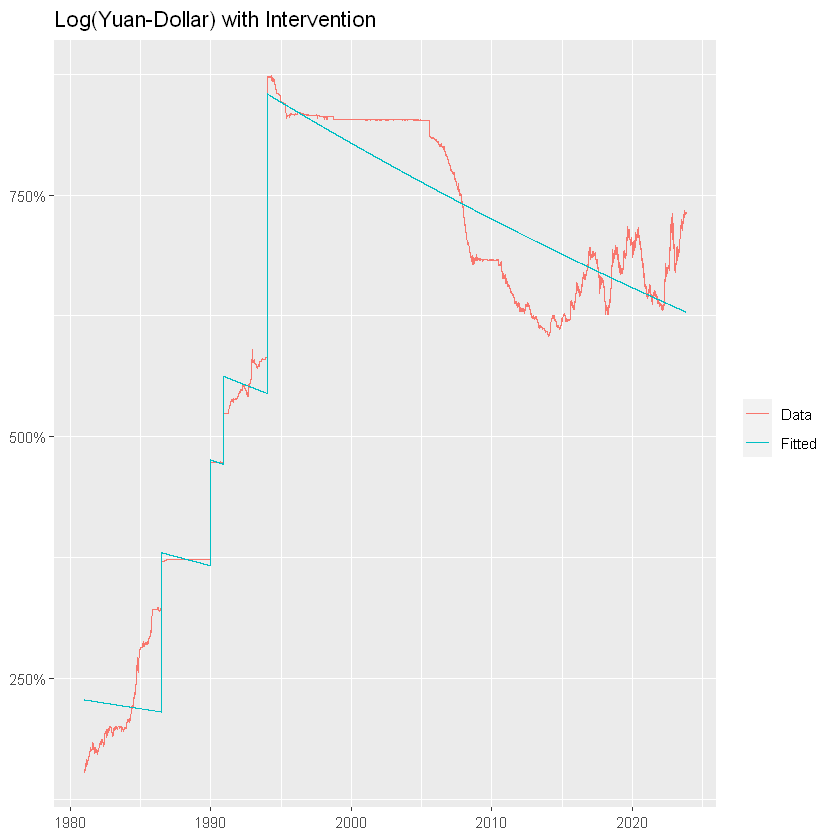

In [39]:
yuan_models_non %>%  select(.model = 'Exponential and Intervention')  %>% report() %>% augment() %>% ggplot(aes(x=day)) +
  geom_line(aes(y=yuan_dollar, colour='Data'), na.rm = TRUE) +
  geom_line(aes(y=.fitted, colour='Fitted'), na.rm = TRUE) +
  labs(y=NULL, title='Log(Yuan-Dollar) with Intervention', x=NULL) +
  scale_y_continuous(labels=scales::percent) +
  guides(colour=guide_legend(title=NULL))

ggsave(paste(plot_prefix, 'log_yuan_trend_intervention.png'), height=3, width=5)

Series: yuan_dollar 
Model: TSLM 

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4377 -0.3570  0.1048  0.4761  0.9603 

Coefficients:
                                                                                                                         Estimate
(Intercept)                                                                                                             1.318e+00
trend(knots = c(as.Date("1986-07-07"), as.Date("1989-12-18"), as.Date("1990-11-19"), as.Date("1993-01-03")))trend       9.890e-04
trend(knots = c(as.Date("1986-07-07"), as.Date("1989-12-18"), as.Date("1990-11-19"), as.Date("1993-01-03")))trend_2013 -3.120e-04
trend(knots = c(as.Date("1986-07-07"), as.Date("1989-12-18"), as.Date("1990-11-19"), as.Date("1993-01-03")))trend_3273 -3.379e-04
trend(knots = c(as.Date("1986-07-07"), as.Date("1989-12-18"), as.Date("1990-11-19"), as.Date("1993-01-03")))trend_3609  4.668e-03
trend(knots = c(as.Date("1986-07-07"), as.Date("1989-12-18"), as.Date("1990-1

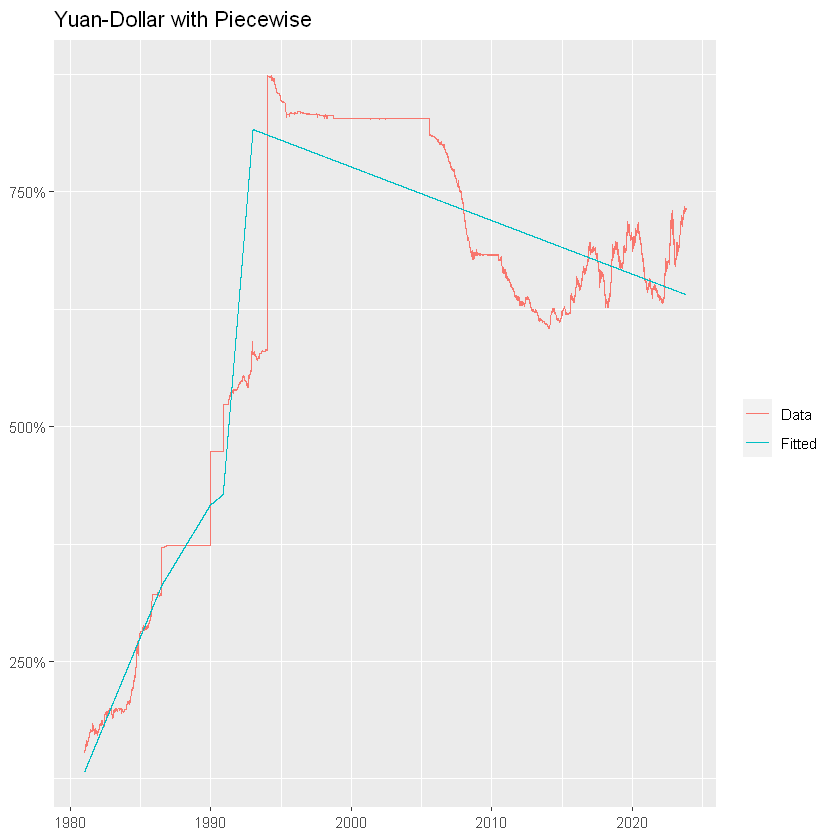

In [40]:
yuan_models_non %>%  select(.model = 'Piecewise Trend')  %>% report() %>% augment() %>% ggplot(aes(x=day)) +
  geom_line(aes(y=yuan_dollar, colour='Data'), na.rm = TRUE) +
  geom_line(aes(y=.fitted, colour='Fitted'), na.rm = TRUE) +
  labs(y=NULL, title='Yuan-Dollar with Piecewise', x=NULL) +
  scale_y_continuous(labels=scales::percent) +
  guides(colour=guide_legend(title=NULL))

ggsave(paste(plot_prefix, 'yuan_trend_piecewise.png'), height=3, width=5)

Series: yuan_dollar 
Model: TSLM 

Residuals:
       Min         1Q     Median         3Q        Max 
-0.1645675 -0.0012196 -0.0003721  0.0005530  2.9037704 

Coefficients:
                                                                                                                         Estimate
(Intercept)                                                                                                             2.318e-03
lag1                                                                                                                    9.981e-01
lag2                                                                                                                    6.182e-04
trend(knots = c(as.Date("1986-07-07"), as.Date("1989-12-18"), as.Date("1990-11-19"), as.Date("1993-01-03")))trend       1.356e-06
trend(knots = c(as.Date("1986-07-07"), as.Date("1989-12-18"), as.Date("1990-11-19"), as.Date("1993-01-03")))trend_2013 -8.163e-08
trend(knots = c(as.Date("1986-07-07"), as.Date(

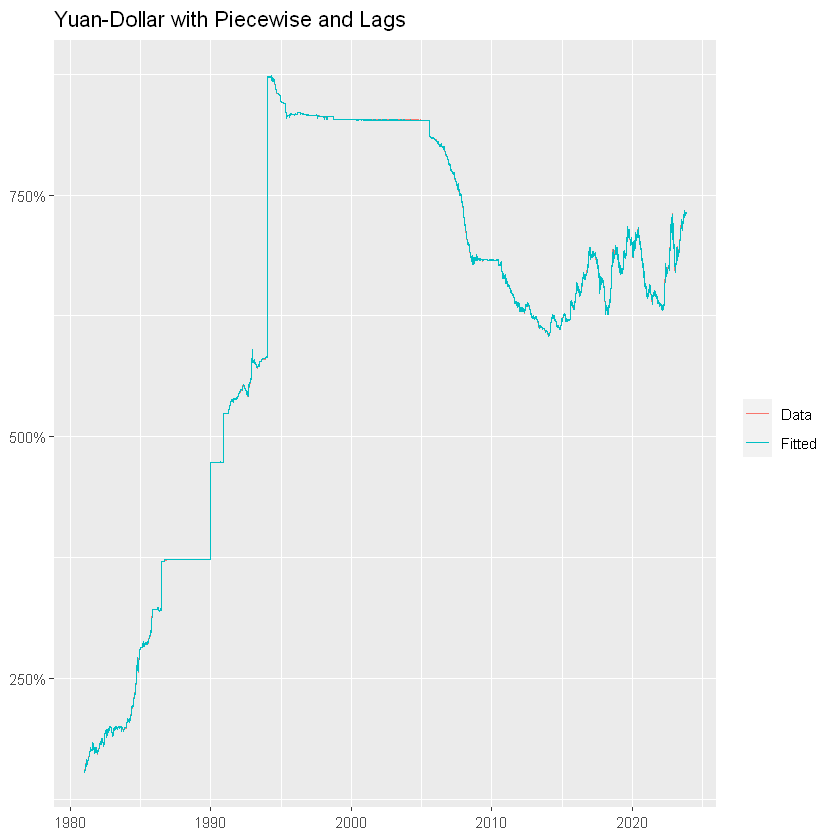

In [41]:
yuan_models_non %>%  select(.model = 'Piecewise Trend Lags')  %>% report() %>% augment() %>% ggplot(aes(x=day)) +
  geom_line(aes(y=yuan_dollar, colour='Data'), na.rm = TRUE) +
  geom_line(aes(y=.fitted, colour='Fitted'), na.rm = TRUE) +
  labs(y=NULL, title='Yuan-Dollar with Piecewise and Lags', x=NULL) +
  scale_y_continuous(labels=scales::percent) +
  guides(colour=guide_legend(title=NULL))

ggsave(paste(plot_prefix, 'yuan_trend_piecewise_lags.png'), height=3, width=5)

Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 2 rows containing non-finite values (`stat_bin()`)."


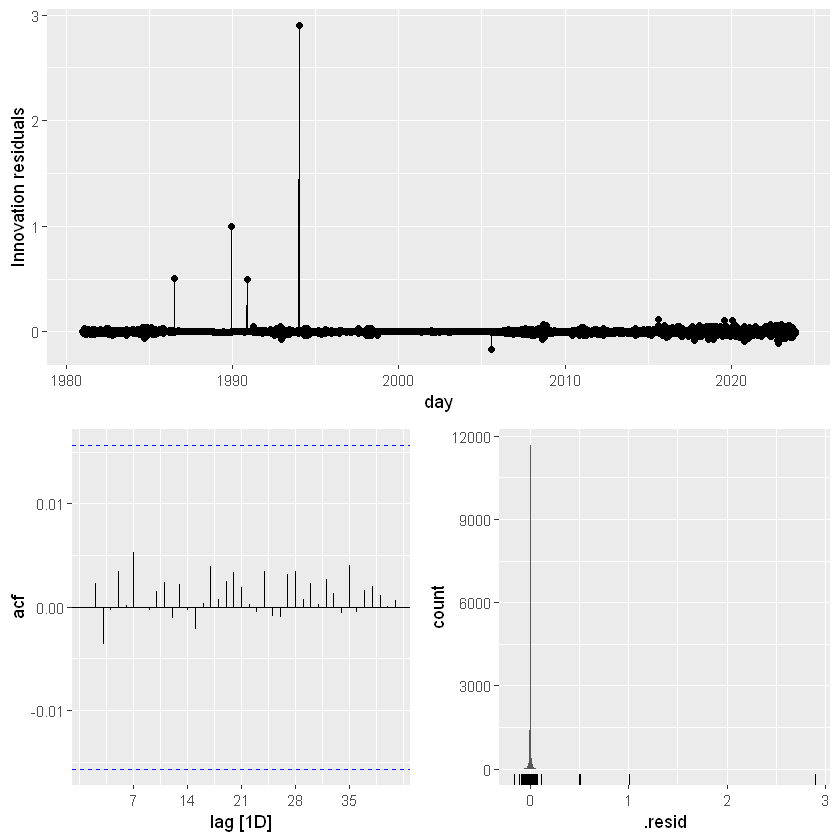

In [42]:
yuan_models_non %>% select(.model = 'Piecewise Trend Lags') %>% gg_tsresiduals()

## Forecasting Gas Prices

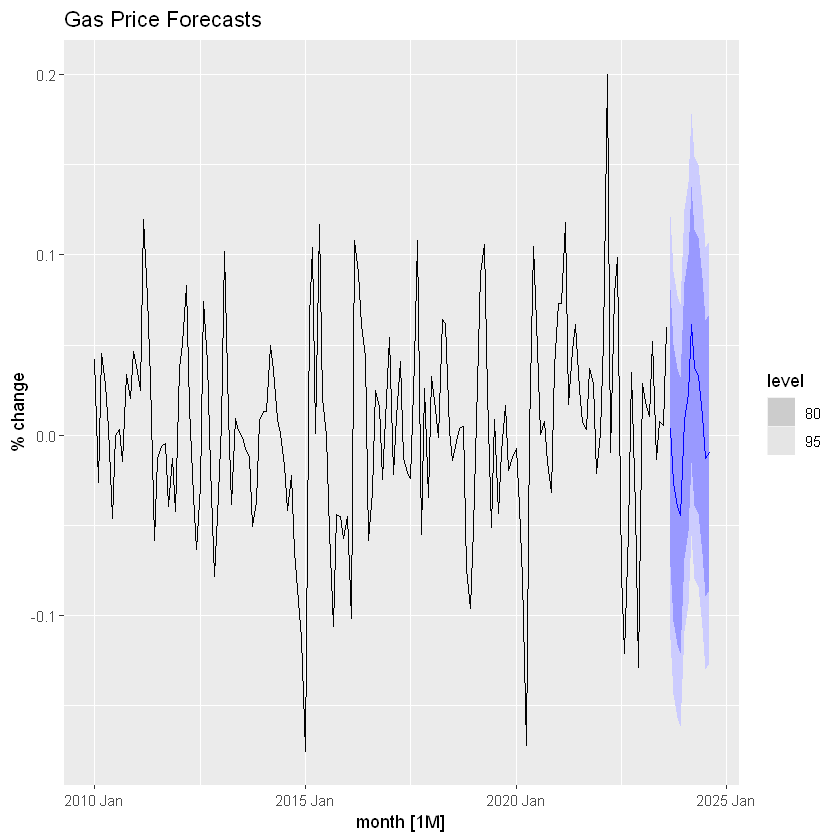

In [43]:
fit_gas <- gas_demand |>
  model(TSLM(gas_price_pct ~ trend() + season()))

fcast <- forecast(fit_gas, h=12)

gas_demand |>
filter_index('2010 Jan' ~ .) |>
  autoplot(gas_price_pct ) +
  autolayer(fcast) +
  labs(title = "Gas Price Forecasts", y = "% change")

ggsave(paste(plot_prefix, 'gas_trend.png'), height=3, width=5)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


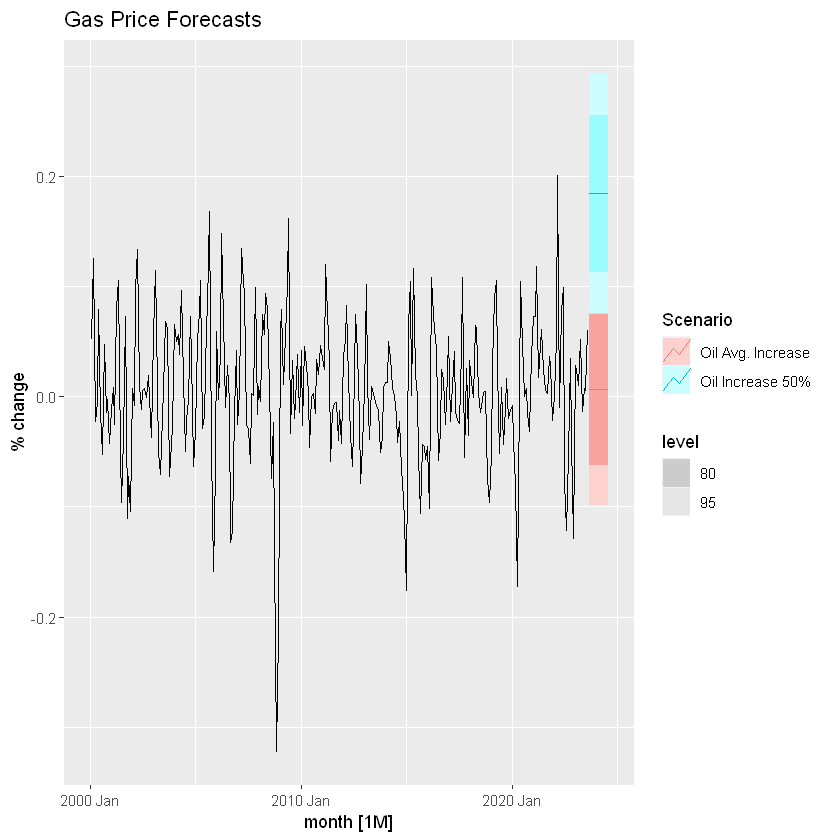

In [44]:
fit_gas <- gas_demand|>
  model(TSLM(gas_price_pct ~ oil_price_pct))

new_gas <- scenarios(
  "Oil Avg. Increase" = new_data(gas_demand, 12) |>
    mutate(oil_price_pct = mean(gas_demand$oil_price_pct, na.rm = TRUE)),
  "Oil Increase 50%" = new_data(gas_demand, 12) |>
    mutate(oil_price_pct = 0.50),
  names_to = "Scenario"
)

fcast <- forecast(fit_gas, new_gas)

gas_demand |>
  autoplot(gas_price_pct) +
  autolayer(fcast) +
  labs(title = "Gas Price Forecasts", y = "% change")

ggsave(paste(plot_prefix, 'gas_scenario.png'), height=3, width=5)